In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
pip install --quiet git+https://github.com/theislab/scgen.git

Note: you may need to restart the kernel to use updated packages.


In [45]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen

In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

### Import the metric -- scib

In [ ]:
!pip install --quiet scib
import scib

In [ ]:
!pip install --quiet louvain
import louvain

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-7-bf0d4c071418>:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be

In [8]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata = anndata.read_h5ad("./Lung_atlas_public.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [12]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.7 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 70% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 70% known labels and 30% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_7482/976909355.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Macrophage', 'Dendritic cell', 'Ciliated', 'Macrophage', 'Macrophage', ..., 'Basal 1', 'Macrophage', 'Macrophage', 'Macrophage', 'Secretory']
Length: 22730
Categories (17, object): ['B cell', 'Basal 1', 'Basal 2', 'Ciliated', ..., 'Secretory', 'T/NK cell', 'Type 1', 'Type 2']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']
/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_7482/976909355.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [14]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [16]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [34]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('./hard_label_lung_atlas_30.csv', index=True)

# scANVI

In [19]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 273/273: 100%|█| 273/273 [13:16<00:00,  2.80s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=273` reached.


Epoch 273/273: 100%|█| 273/273 [13:16<00:00,  2.92s/it, v_num=1, train_loss_step


In [20]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

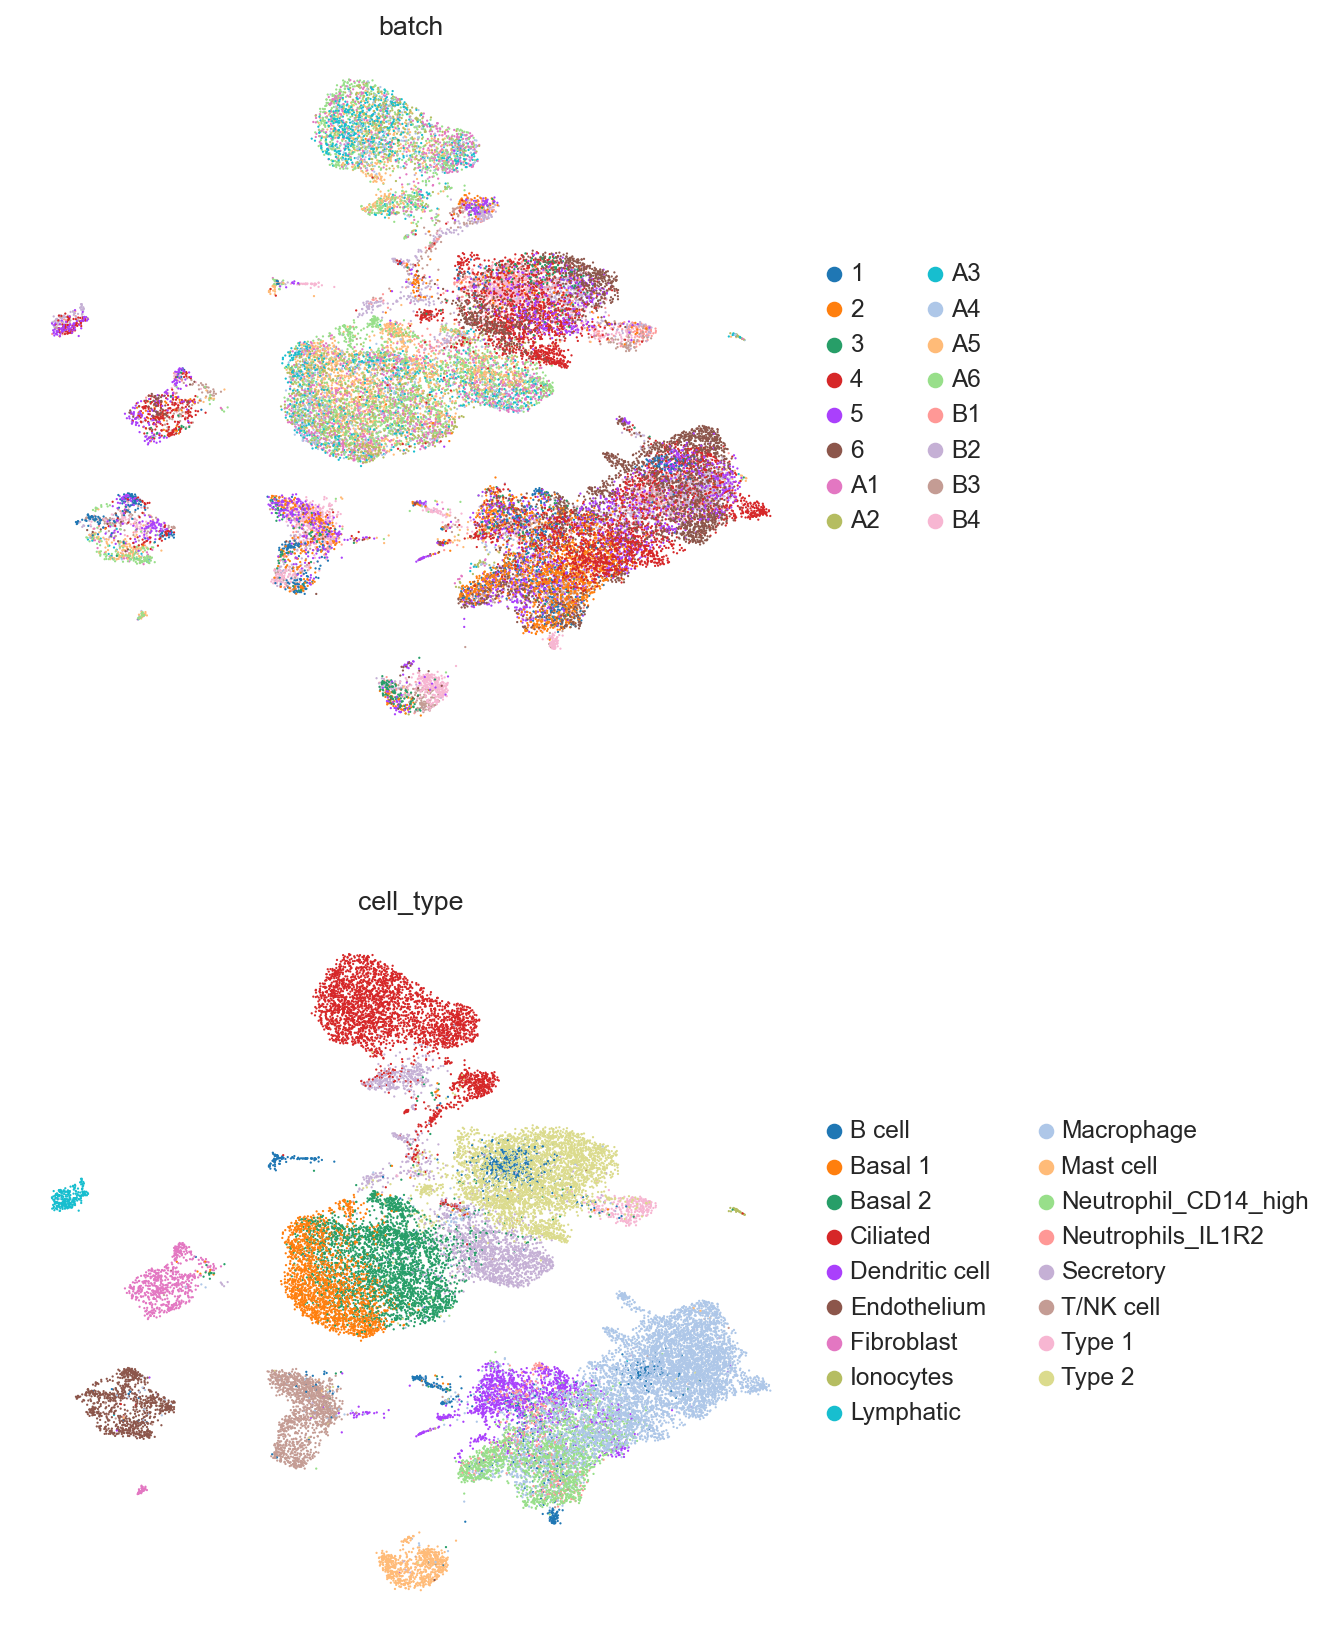

In [21]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [36]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [38]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [02:39<00:00, 10.02s/it, v_num=1, train_loss_step=421

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [02:39<00:00,  7.97s/it, v_num=1, train_loss_step=421


In [39]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [40]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [41]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

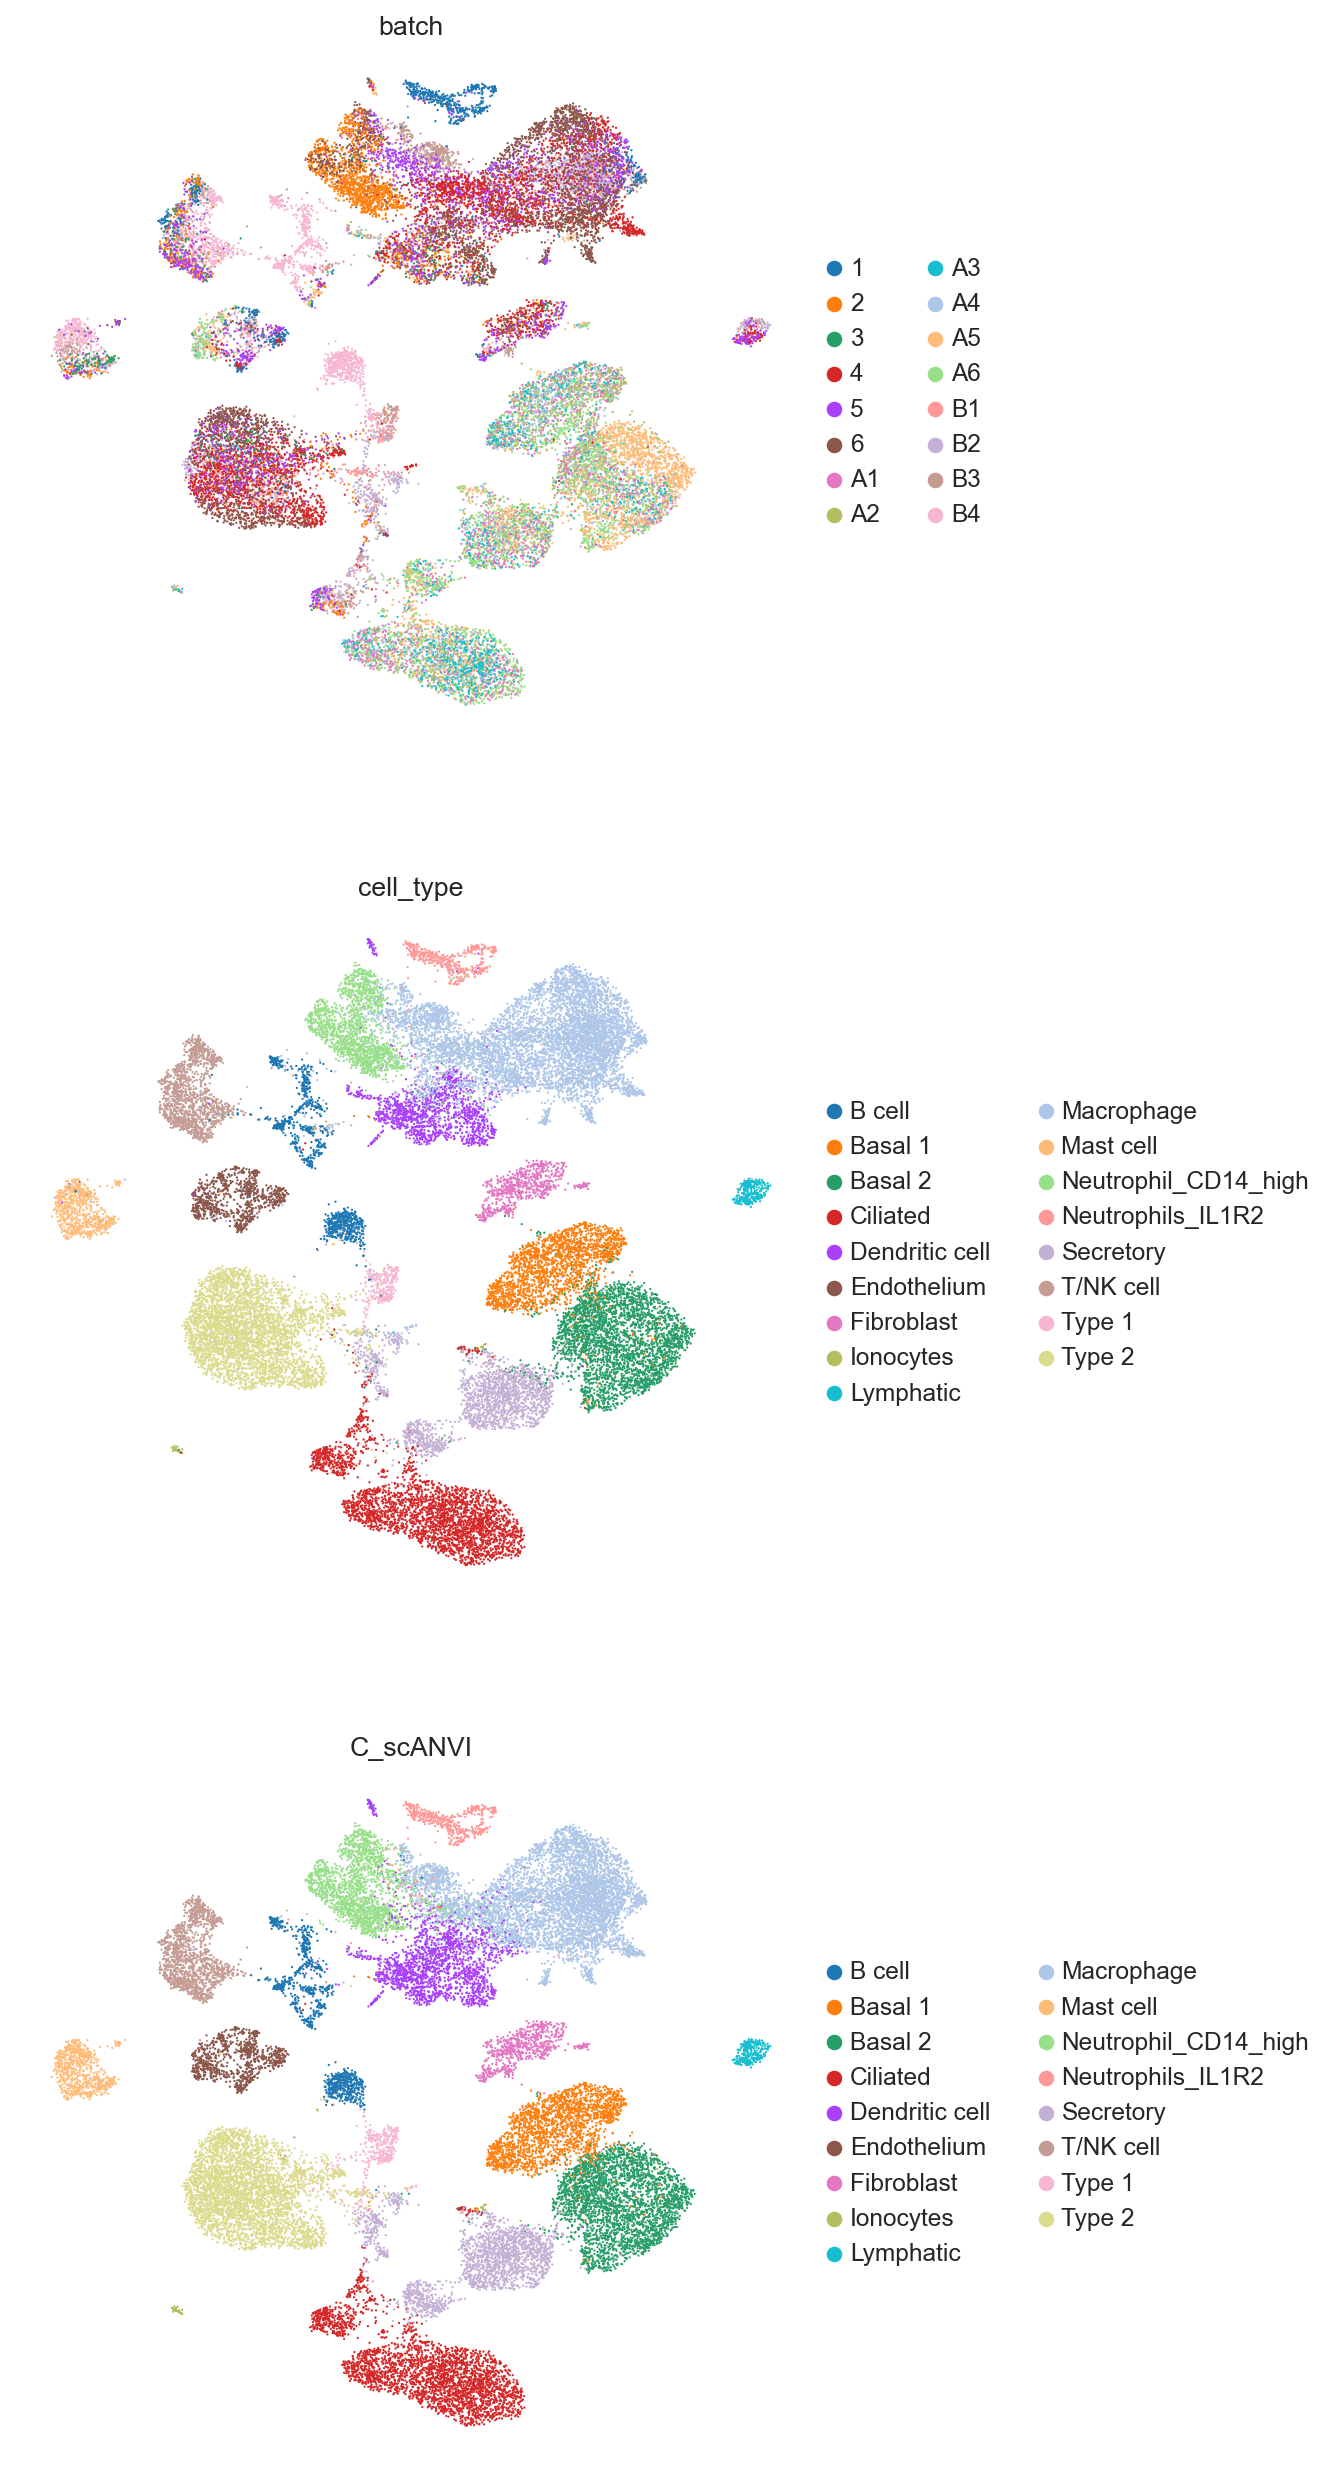

In [42]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [46]:
train = adata.copy()

### Preprocessing Data

In [48]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [50]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|▎| 26/100 [16:24<46:43, 37.88s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1163.260. Signaling Trainer to stop.


## Batch-Removal

In [52]:
corrected_adata = model.batch_removal()
corrected_adata

/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 29256 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'hard_label', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [88]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [55]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


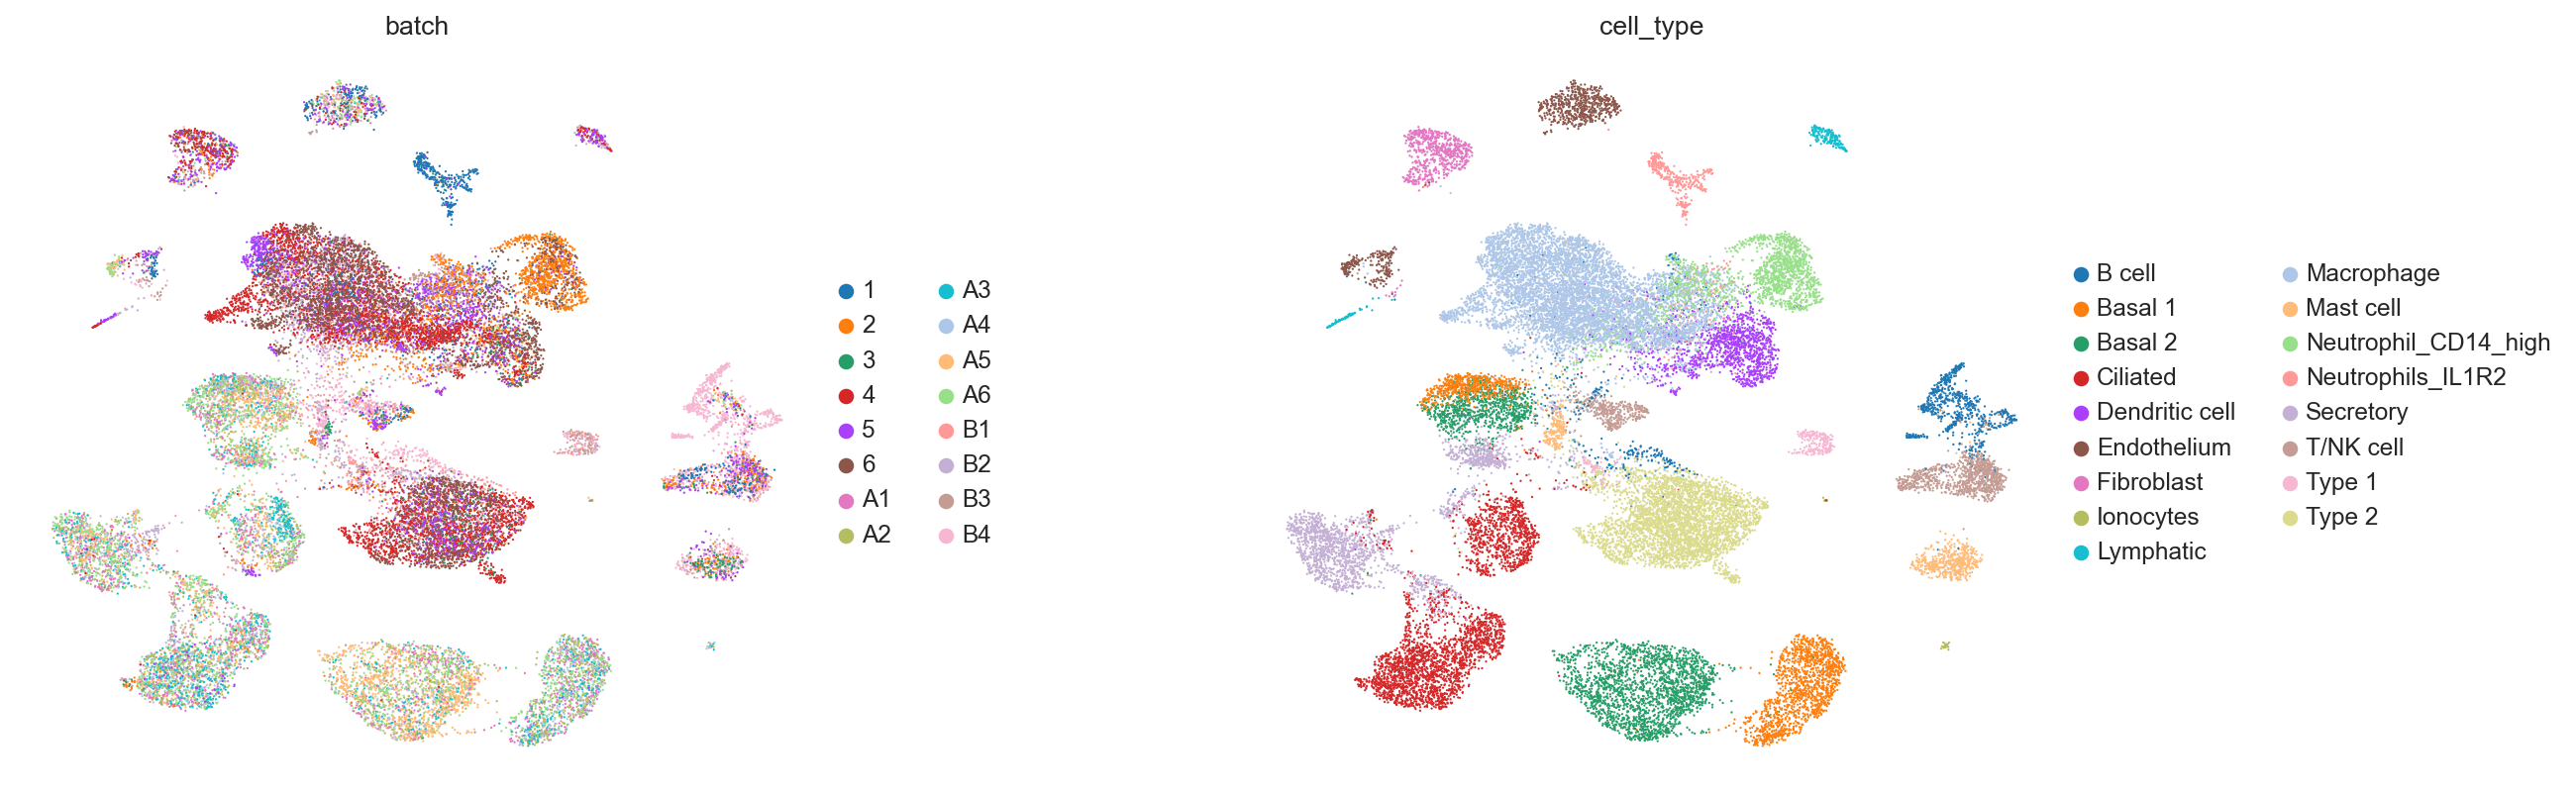

In [56]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [82]:
pca_embeddings = pd.read_csv('./lung_atlas_stacas_embeddings_randomly_missing_labels_30.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [83]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

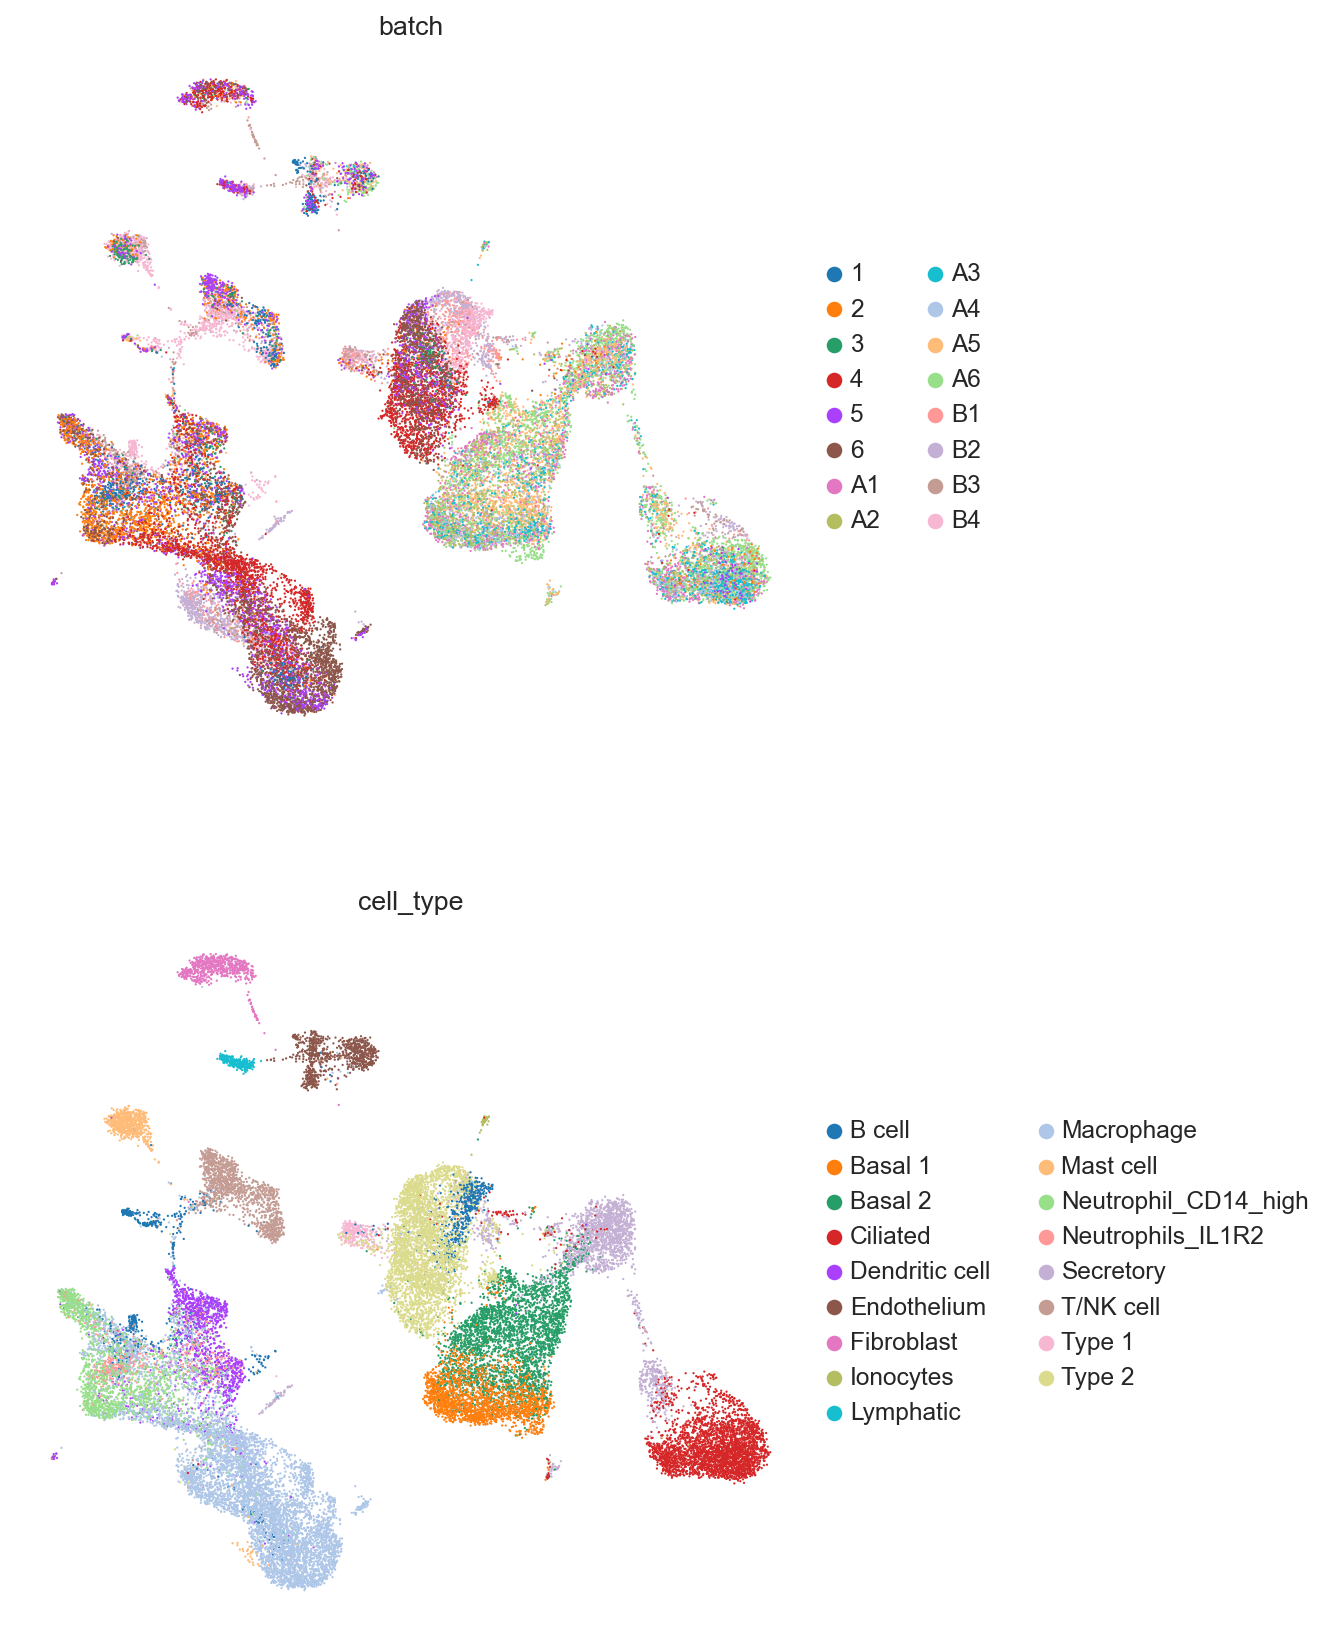

In [84]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [90]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./randomly_missing_lung_atlas_30.csv")


# Metric Evaluation

## read the embeddings

In [ ]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("/content/drive/MyDrive/scdata/Lung_atlas_public/randomly_missing_lung_atlas_30.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-12-1769301acfa0>:13: ImplicitModificationWarning: Setting element `.obsm['X_scANVI']` of view, initializing view as actu

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

resolution: 0.1, nmi: 0.7984748301371408
resolution: 0.2, nmi: 0.8354704360986134
resolution: 0.3, nmi: 0.856454364072469
resolution: 0.4, nmi: 0.8493473711754915
resolution: 0.5, nmi: 0.8413108882248864
resolution: 0.6, nmi: 0.8302462470144479
resolution: 0.7, nmi: 0.8258645619779226
resolution: 0.8, nmi: 0.8208962489139565
resolution: 0.9, nmi: 0.8078866206661411
resolution: 1.0, nmi: 0.7907776528098098
resolution: 1.1, nmi: 0.7735701384524343
resolution: 1.2, nmi: 0.7745937918539397
resolution: 1.3, nmi: 0.7670880777600124
resolution: 1.4, nmi: 0.7658351133142609
resolution: 1.5, nmi: 0.7563187941176533
resolution: 1.6, nmi: 0.7558723984968897
resolution: 1.7, nmi: 0.7541591608059277
resolution: 1.8, nmi: 0.750569963796661
resolution: 1.9, nmi: 0.7451431171011725
resolution: 2.0, nmi: 0.7419246491796658
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.856454364072469


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remove

Isolated labels F1...
Compute neighbors on rep X_scANVI
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


In [ ]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.690782205020978
resolution: 0.2, nmi: 0.7107819278080704
resolution: 0.3, nmi: 0.7186416768715587
resolution: 0.4, nmi: 0.7264105458788879
resolution: 0.5, nmi: 0.7309072249416733
resolution: 0.6, nmi: 0.7286288701881901
resolution: 0.7, nmi: 0.7309373683034872
resolution: 0.8, nmi: 0.7116318870074031
resolution: 0.9, nmi: 0.7108563057110396
resolution: 1.0, nmi: 0.7089801443398923
resolution: 1.1, nmi: 0.7103497807283081
resolution: 1.2, nmi: 0.708963795775918
resolution: 1.3, nmi: 0.7006684979167583
resolution: 1.4, nmi: 0.7009382704693811
resolution: 1.5, nmi: 0.7000590515607915
resolution: 1.6, nmi: 0.6930152819378569
resolution: 1.7, nmi: 0.6908906316296838
resolution: 1.8, nmi: 0.6865646599649179
resolution: 1.9, nmi: 0.6825319583238373
resolution: 2.0, nmi: 0.6820747648971675
optimised clustering against cell_type
optimal cluster resolution: 0.7
optimal score: 0.7309373683034872


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...
Compute neighbors on rep X_scgen
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP


In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.7044616610136725
resolution: 0.2, nmi: 0.7600115168974061
resolution: 0.3, nmi: 0.76245945545276
resolution: 0.4, nmi: 0.7597932241151901
resolution: 0.5, nmi: 0.7517272545643131
resolution: 0.6, nmi: 0.737431554787397
resolution: 0.7, nmi: 0.7325154840153146
resolution: 0.8, nmi: 0.7176041800904039
resolution: 0.9, nmi: 0.7103587502403133
resolution: 1.0, nmi: 0.7125297521548499
resolution: 1.1, nmi: 0.7062658948775377
resolution: 1.2, nmi: 0.6983773308655198
resolution: 1.3, nmi: 0.698265133220407
resolution: 1.4, nmi: 0.6967743224623498
resolution: 1.5, nmi: 0.6790300494062774
resolution: 1.6, nmi: 0.6639190516331402
resolution: 1.7, nmi: 0.668578305381628
resolution: 1.8, nmi: 0.6660938186760678
resolution: 1.9, nmi: 0.6599659550687238
resolution: 2.0, nmi: 0.6653068083145558
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.76245945545276


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...
Compute neighbors on rep X_stacas
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

scANVI     scGEN    STACAS
NMI_cluster/label          0.851826  0.738477  0.751288
ARI_cluster/label          0.801957  0.634294  0.597219
ASW_label                  0.645392  0.559160  0.584224
ASW_label/batch            0.868600  0.868236  0.847850
PCR_batch                       NaN       NaN       NaN
cell_cycle_conservation         NaN       NaN       NaN
isolated_label_F1          0.903752  0.715528  0.680905
isolated_label_silhouette  0.715138  0.571057  0.592323
graph_conn                 0.990808  0.951595  0.957764
kBET                            NaN       NaN       NaN
iLISI                      0.131021  0.120726  0.163300
cLISI                      0.999471  0.995666  0.992376
hvg_overlap                     NaN       NaN       NaN
trajectory                      NaN       NaN       NaN